In [6]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM,BatchNormalization , GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf 
print ("Done")

Done


In [7]:
def count_unique_values(dataframe):
    unique_value_counts = {}
    for column in dataframe.columns:
        unique_value_counts[column] = dataframe[column].value_counts().to_dict()
    return unique_value_counts

In [15]:
df = pd.read_csv('C:/Users/Recherche2/Desktop/clear_two/filtered_df.csv')

In [9]:
result_count = count_unique_values(df[['label']])
print(result_count)

{'label': {'Engagement': 165, 'Contempt': 113, 'Sadness': 40, 'Sentimentality': 15, 'Fear': 11, 'Confusion': 8}}


In [17]:
# Define the mapping
label_mapping = {
    'Engagement': 5,
    'Contempt': 4,
    'Sadness': 3,
    'Sentimentality': 2,
    'Fear': 1,
    'Confusion': 0
}

# Map the label values using the provided mapping
df['Label_Encoded'] = df['label'].map(label_mapping)

# Print the updated DataFrame
df.drop(columns=['Unnamed: 0','label'], axis=1, inplace=True)
df

path  Label_Encoded
0    C:/Users/Recherche2/Desktop/clear_two/second_a...              4
1    C:/Users/Recherche2/Desktop/clear_two/second_a...              4
2    C:/Users/Recherche2/Desktop/clear_two/second_a...              4
3    C:/Users/Recherche2/Desktop/clear_two/second_a...              0
4    C:/Users/Recherche2/Desktop/clear_two/second_a...              4
..                                                 ...            ...
347  C:/Users/Recherche2/Desktop/clear_two/audio/Et...              5
348  C:/Users/Recherche2/Desktop/clear_two/audio/Et...              5
349  C:/Users/Recherche2/Desktop/clear_two/audio/Et...              5
350  C:/Users/Recherche2/Desktop/clear_two/audio/Et...              5
351  C:/Users/Recherche2/Desktop/clear_two/audio/Et...              5

[352 rows x 2 columns]

In [19]:
file_paths_df = pd.DataFrame(df, columns=['path'])

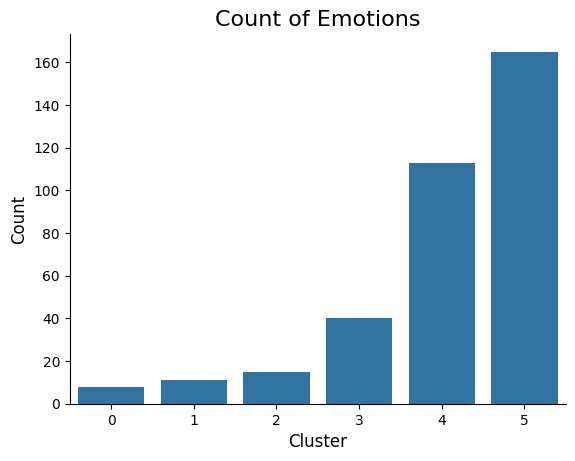

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(data=df, x='Label_Encoded')  # Use x='Cluster' to specify the column name
plt.ylabel('Count', size=12)
plt.xlabel('Cluster', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [20]:
data,sr = librosa.load(df['path'][0])
sr

22050

In [21]:
ipd.Audio(data,rate=sr)

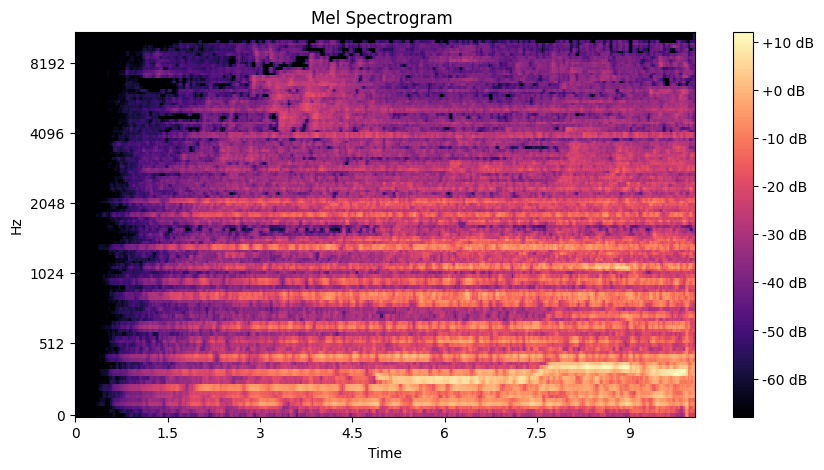

In [22]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

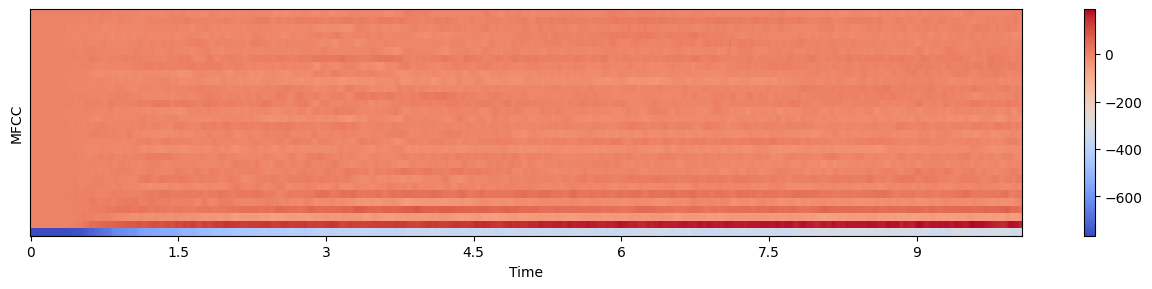

In [23]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

# Data Augmentation

Adding different types of changes on the audio, to increase data and robustness of the model to different varitaion of the same emotion.

In [24]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

Visualising the different effects on the same audio.

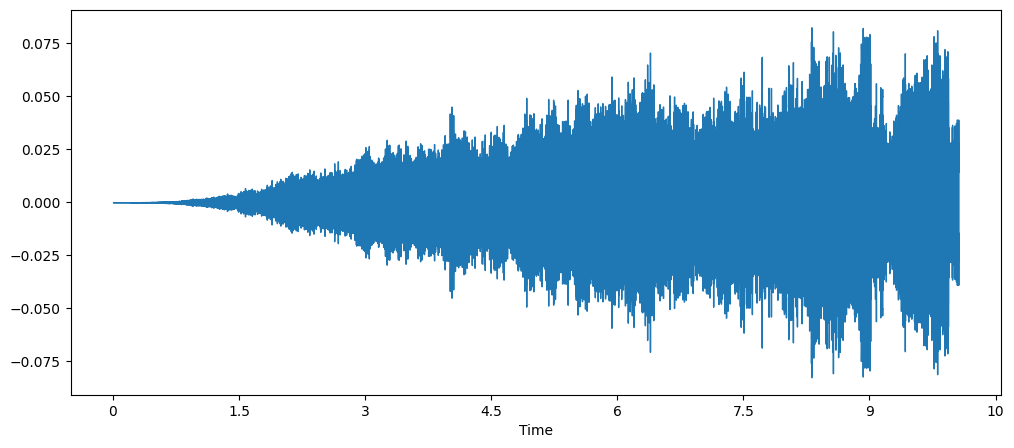

In [25]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

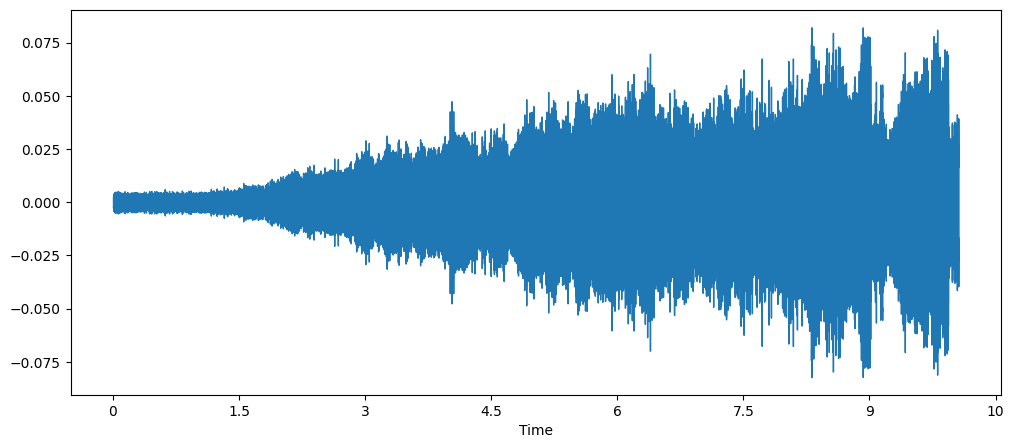

In [26]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

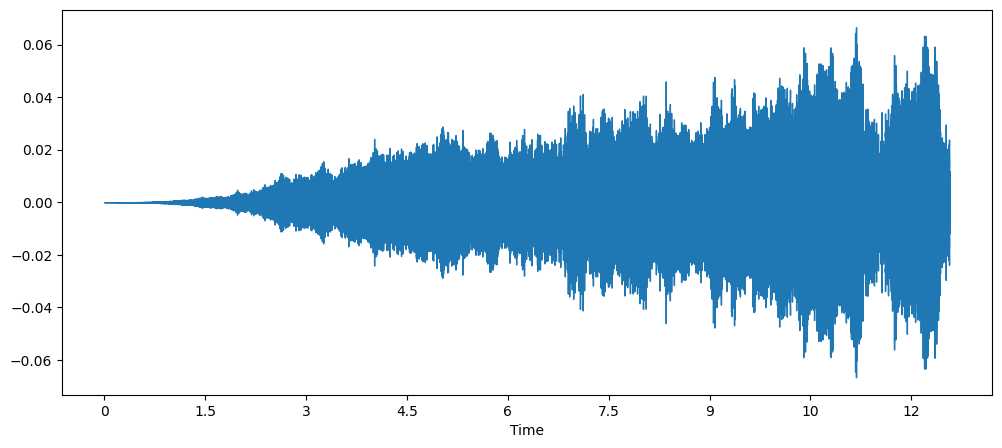

In [27]:
# STRETCHED AUDIO
x = stretch(data,0.8)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

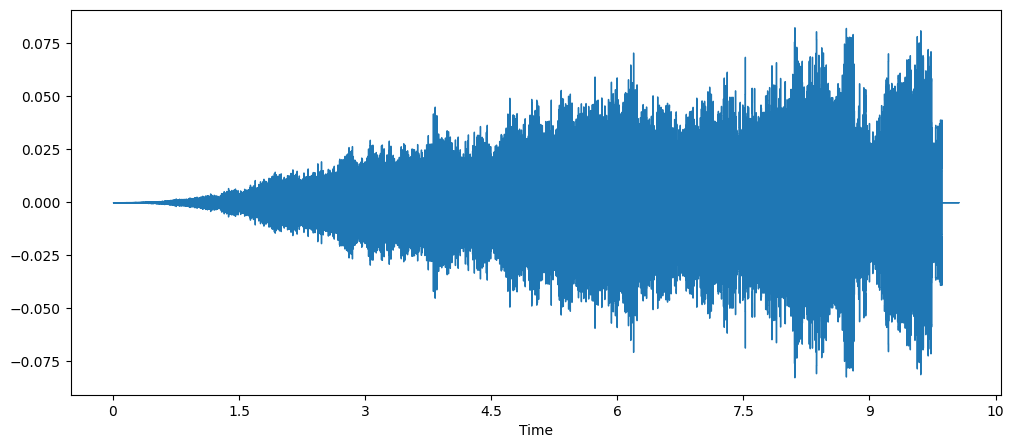

In [28]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

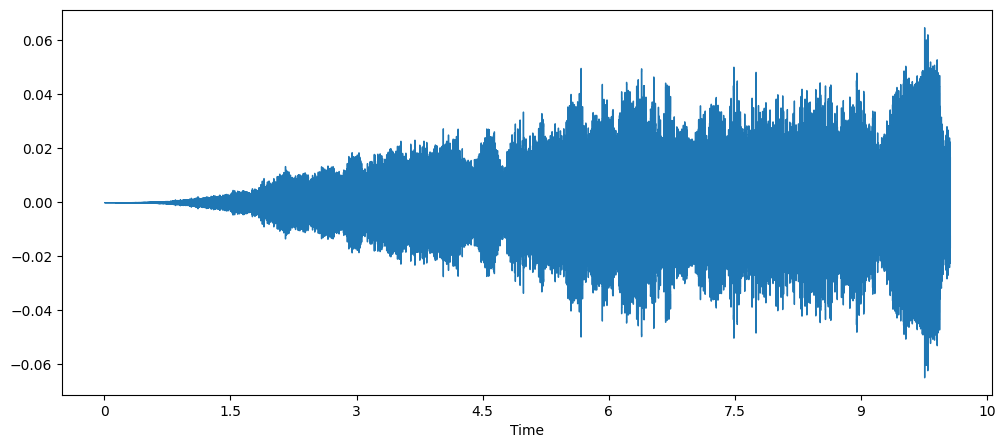

In [29]:
# AUDIO WITH PITCH
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

# Feature Extraction
* Zero Crossing Rate

Defeine when the singal crosses the zero line or changes its sign.
Indicates the humming melodie, rythm and sharpness (quick sharp sounds).

* Root Mean Square

Measure the average square between amplitudes.
Indicates the loudiness or softness of the sound.

* Mel Frequency Cepestral Coefficient

Measure the spectral (Energies) spread along the signal.
Roughly detects the different instruments used depending on their energy.


In [31]:
# Zero crossing rate
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)

# Root mean square
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)

# Mel-Frequency Cepstral coefficient
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

# Combine all feature functions
def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

# Apply data augmentation and extract its features
def get_features(path,duration=10, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset,mono=True)
    aud=extract_features(data)
    audio=np.array(aud)
    
    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))
    
    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))
    
    return audio

In [32]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  16


In [34]:
df.path.shape[0]

352

In [36]:
import timeit
from tqdm import tqdm

# Extract the features.
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(df.path,df.Label_Encoded,range(df.path.shape[0]))):
    features=get_features(path)
    if index%100==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

1it [00:00,  2.98it/s]

0 audio has been processed


101it [00:36,  2.85it/s]

100 audio has been processed


201it [01:13,  2.82it/s]

200 audio has been processed


301it [01:50,  2.58it/s]

300 audio has been processed


352it [02:09,  2.72it/s]

Done
Time:  129.57735230005346


In [37]:
len(X), len(Y), df.path.shape

(1408, 1408, (352,))

In [38]:
# Save the features in a CSV file
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()
Emotions.tail()

0         1         2         3         4         5         6  \
1403  0.039551  0.065918  0.093750  0.116699  0.135742  0.145996  0.160645   
1404  0.062988  0.096191  0.133789  0.132812  0.137207  0.133301  0.134766   
1405  0.067871  0.102051  0.143555  0.142578  0.146973  0.144531  0.144531   
1406  0.060547  0.092285  0.126953  0.132812  0.139160  0.139160  0.139648   
1407  0.063477  0.098145  0.132812  0.138672  0.145996  0.144043  0.150391   

             7         8         9  ...       8967       8968       8969  \
1403  0.151367  0.160156  0.170898  ...   6.625856   4.365361 -10.085202   
1404  0.132812  0.134277  0.134277  ... -25.546721 -14.771671  -1.831831   
1405  0.147461  0.149902  0.147949  ... -22.247457 -16.241484   1.240468   
1406  0.132324  0.127930  0.121582  ... -23.068150  -7.332281  12.741880   
1407  0.142090  0.136719  0.130371  ... -22.644073  -3.487986  14.810538   

           8970       8971      8972      8973       8974       8975  Emotions  
1403  -7.594307  -3.081189 -6.002972 -2.204407  -4.062688  -3.591580         5  
1404  12.304682  -9.325563 -5.296636 -7.854189  -9.784828 -19.563190         5  
1405   8.169269  -2.732721 -6.628303 -5.469353  -9.795337 -18.881717         5  
1406  13.970737 -11.189439 -3.144578 -7.601496 -10.963995 -15.695650         5  
1407  13.361752  -0.488116 -5.343004 -6.885708 -17.542842 -13.493328         5  

[5 rows x 8977 columns]

In [39]:
Emotions.shape

(1408, 8977)

# Feature preparation and cleaning¶
Check if there are any errors or empty data

In [40]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
8972        False
8973        False
8974        False
8975        False
Emotions    False
Length: 8977, dtype: bool


In [41]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
8972        False
8973        False
8974        False
8975        False
Emotions    False
Length: 8977, dtype: bool


(1408, 8977)

In [42]:
np.sum(Emotions.isna())

0           0
1           0
2           0
3           0
4           0
           ..
8972        0
8973        0
8974        0
8975        0
Emotions    0
Length: 8977, dtype: int64

In [43]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions


X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [44]:
Y

array([4, 4, 4, ..., 5, 5, 5], dtype=int64)

In [45]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [46]:
print(Y.shape)

X.shape

(1408, 6)


(1408, 8976)

In [47]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1126, 8976), (1126, 6), (282, 8976), (282, 6))

In [48]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [49]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1126, 8976), (1126, 6), (282, 8976), (282, 6))

# Model archeticture
After several tries and test, this produced best result. Tried bigger Network with more depths and width, but it produced worst result and caused gradient explosion. This is due to the simple task and features so it required simpler model.

In [52]:
import tensorflow.keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM,BatchNormalization , GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [71]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('C:/Users/Recherche2/Desktop/clear_two/path_to_your_model.keras', monitor='val_accuracy', save_best_only=True)

In [72]:
early_stop=EarlyStopping(monitor='val_accuracy',mode='max',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001,mode='min')

In [73]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((1126, 8976, 1), (1126, 6), (282, 8976, 1), (282, 6))

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPool1D, Dropout, Flatten, Dense


model = Sequential([
    Conv1D(16, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPool1D(pool_size=5, strides=2, padding='same'),
    
    Conv1D(8,kernel_size=3,strides=1,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.3),  # Add dropout layer after the fifth max pooling layer
    
    Flatten(),
    Dense(8,activation='relu'),
    BatchNormalization(),
    Dense(6,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 8976, 16)       │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 8976, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 4488, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 4488, 8)        │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 4488, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 2244, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2244, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 17952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │       143,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │            54 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144,294 (563.65 KB)

 Trainable params: 144,230 (563.40 KB)

 Non-trainable params: 64 (256.00 B)

In [75]:
history=model.fit(x_traincnn, y_train,
                  epochs=30,
                  validation_data=(x_testcnn, y_test),
                  batch_size=16,
                  callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.3272 - loss: 1.7617 - val_accuracy: 0.3475 - val_loss: 1.6861 - learning_rate: 0.0010
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6623 - loss: 1.3011 - val_accuracy: 0.3262 - val_loss: 1.8434 - learning_rate: 0.0010
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7657 - loss: 1.0056 - val_accuracy: 0.3298 - val_loss: 1.7061 - learning_rate: 0.0010
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8332 - loss: 0.7643 - val_accuracy: 0.4645 - val_loss: 1.3546 - learning_rate: 0.0010
Epoch 5/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8881 - loss: 0.5399
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8879 - loss: 0.5400 - val_accuracy: 0.5780 - val_loss: 1.1269 - learning_rate: 0.0010
Epoch 6/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9202 - loss: 0.4559 - val_accu

In [76]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9574 - loss: 0.3151
Accuracy of our model on test data :  93.97163391113281 %


In [77]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicted Labels  Actual Labels
0                 3              3
1                 5              5
2                 3              3
3                 5              5
4                 5              5
5                 4              4
6                 4              4
7                 4              4
8                 5              5
9                 5              5

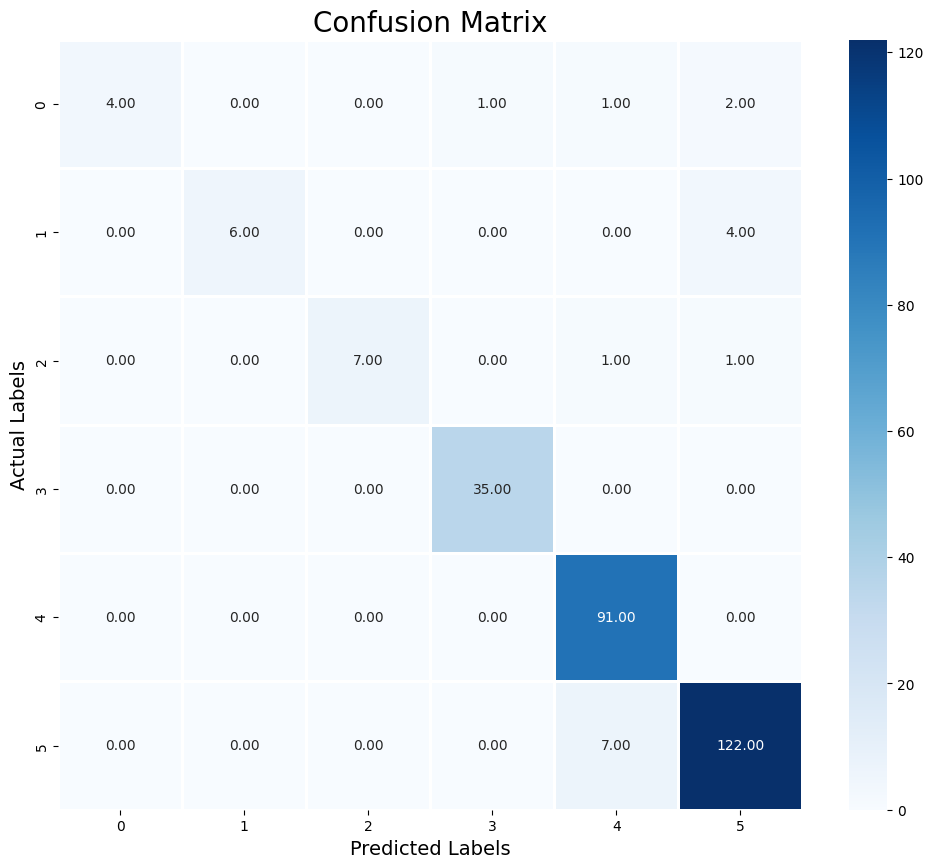

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       1.00      0.60      0.75        10
           2       1.00      0.78      0.88         9
           3       0.97      1.00      0.99        35
           4       0.91      1.00      0.95        91
           5       0.95      0.95      0.95       129

    accuracy                           0.94       282
   macro avg       0.97      0.80      0.86       282
weighted avg       0.94      0.94      0.94       282



In [78]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))